# Modelo de clasificación multiclase

## Importaciones de paquetes necesarios

In [2]:
import os
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50, InceptionV3, DenseNet121
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
print(len(tf.config.list_physical_devices('GPU'))>0)

2.15.0
False


## Carga de datos

Descargamos el conjunto de imágenes que usaremos para entrenar el modelo.

In [ ]:
# if "food-101" in os.listdir():
#   print("Ya tienes las imágenes de food101")
# else:
#   print("Se van a descargar las imágenes...")
#   !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
#   food_tar = tarfile.open('food-101.tar.gz')
#   food_tar.extractall('.')
#   food_tar.close()

Guardamos la ruta donde estarán las imágenes en una variable.

In [3]:
base_dir = 'food-101/images'

Guardamos en una lista todos los nombres de las clases de platos de comida que hay.

## Visualización de las imágenes



In [4]:
class_names = sorted(os.listdir(base_dir))
print(class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [5]:
subdirectories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

for subdirectory in subdirectories:
    image_pattern = os.path.join(base_dir, subdirectory, '*.jpg')
    image_files = glob(image_pattern)
    
    print(f"Directorio '{subdirectory}' contiene {len(image_files)} imágenes.")

Directorio 'apple_pie' contiene 1000 imágenes.
Directorio 'baby_back_ribs' contiene 1000 imágenes.
Directorio 'baklava' contiene 1000 imágenes.
Directorio 'beef_carpaccio' contiene 1000 imágenes.
Directorio 'beef_tartare' contiene 1000 imágenes.
Directorio 'beet_salad' contiene 1000 imágenes.
Directorio 'beignets' contiene 1000 imágenes.
Directorio 'bibimbap' contiene 1000 imágenes.
Directorio 'bread_pudding' contiene 1000 imágenes.
Directorio 'breakfast_burrito' contiene 1000 imágenes.
Directorio 'bruschetta' contiene 1000 imágenes.
Directorio 'caesar_salad' contiene 1000 imágenes.
Directorio 'cannoli' contiene 1000 imágenes.
Directorio 'caprese_salad' contiene 1000 imágenes.
Directorio 'carrot_cake' contiene 1000 imágenes.
Directorio 'ceviche' contiene 1000 imágenes.
Directorio 'cheesecake' contiene 1000 imágenes.
Directorio 'cheese_plate' contiene 1000 imágenes.
Directorio 'chicken_curry' contiene 1000 imágenes.
Directorio 'chicken_quesadilla' contiene 1000 imágenes.
Directorio 'chi

In [6]:
meta_path = 'food-101/meta/' 
train_path = meta_path+'train.txt'
test_path = meta_path+'test.txt'
# Train
line_count = 0
with open(train_path, 'r') as file:
    for line in file:
        line_count += 1
print(f"El archivo '{train_path}' contiene {line_count} datos de entrenamiento.")        
#Test
line_count = 0
with open(test_path, 'r') as file:
    for line in file:
        line_count += 1

print(f"El archivo '{test_path}' contiene {line_count} datos de test.")        

El archivo 'food-101/meta/train.txt' contiene 75750 datos de entrenamiento.
El archivo 'food-101/meta/test.txt' contiene 25250 datos de test.


A continuación vamos a visualizar una imagen aleatoria para cada clase.

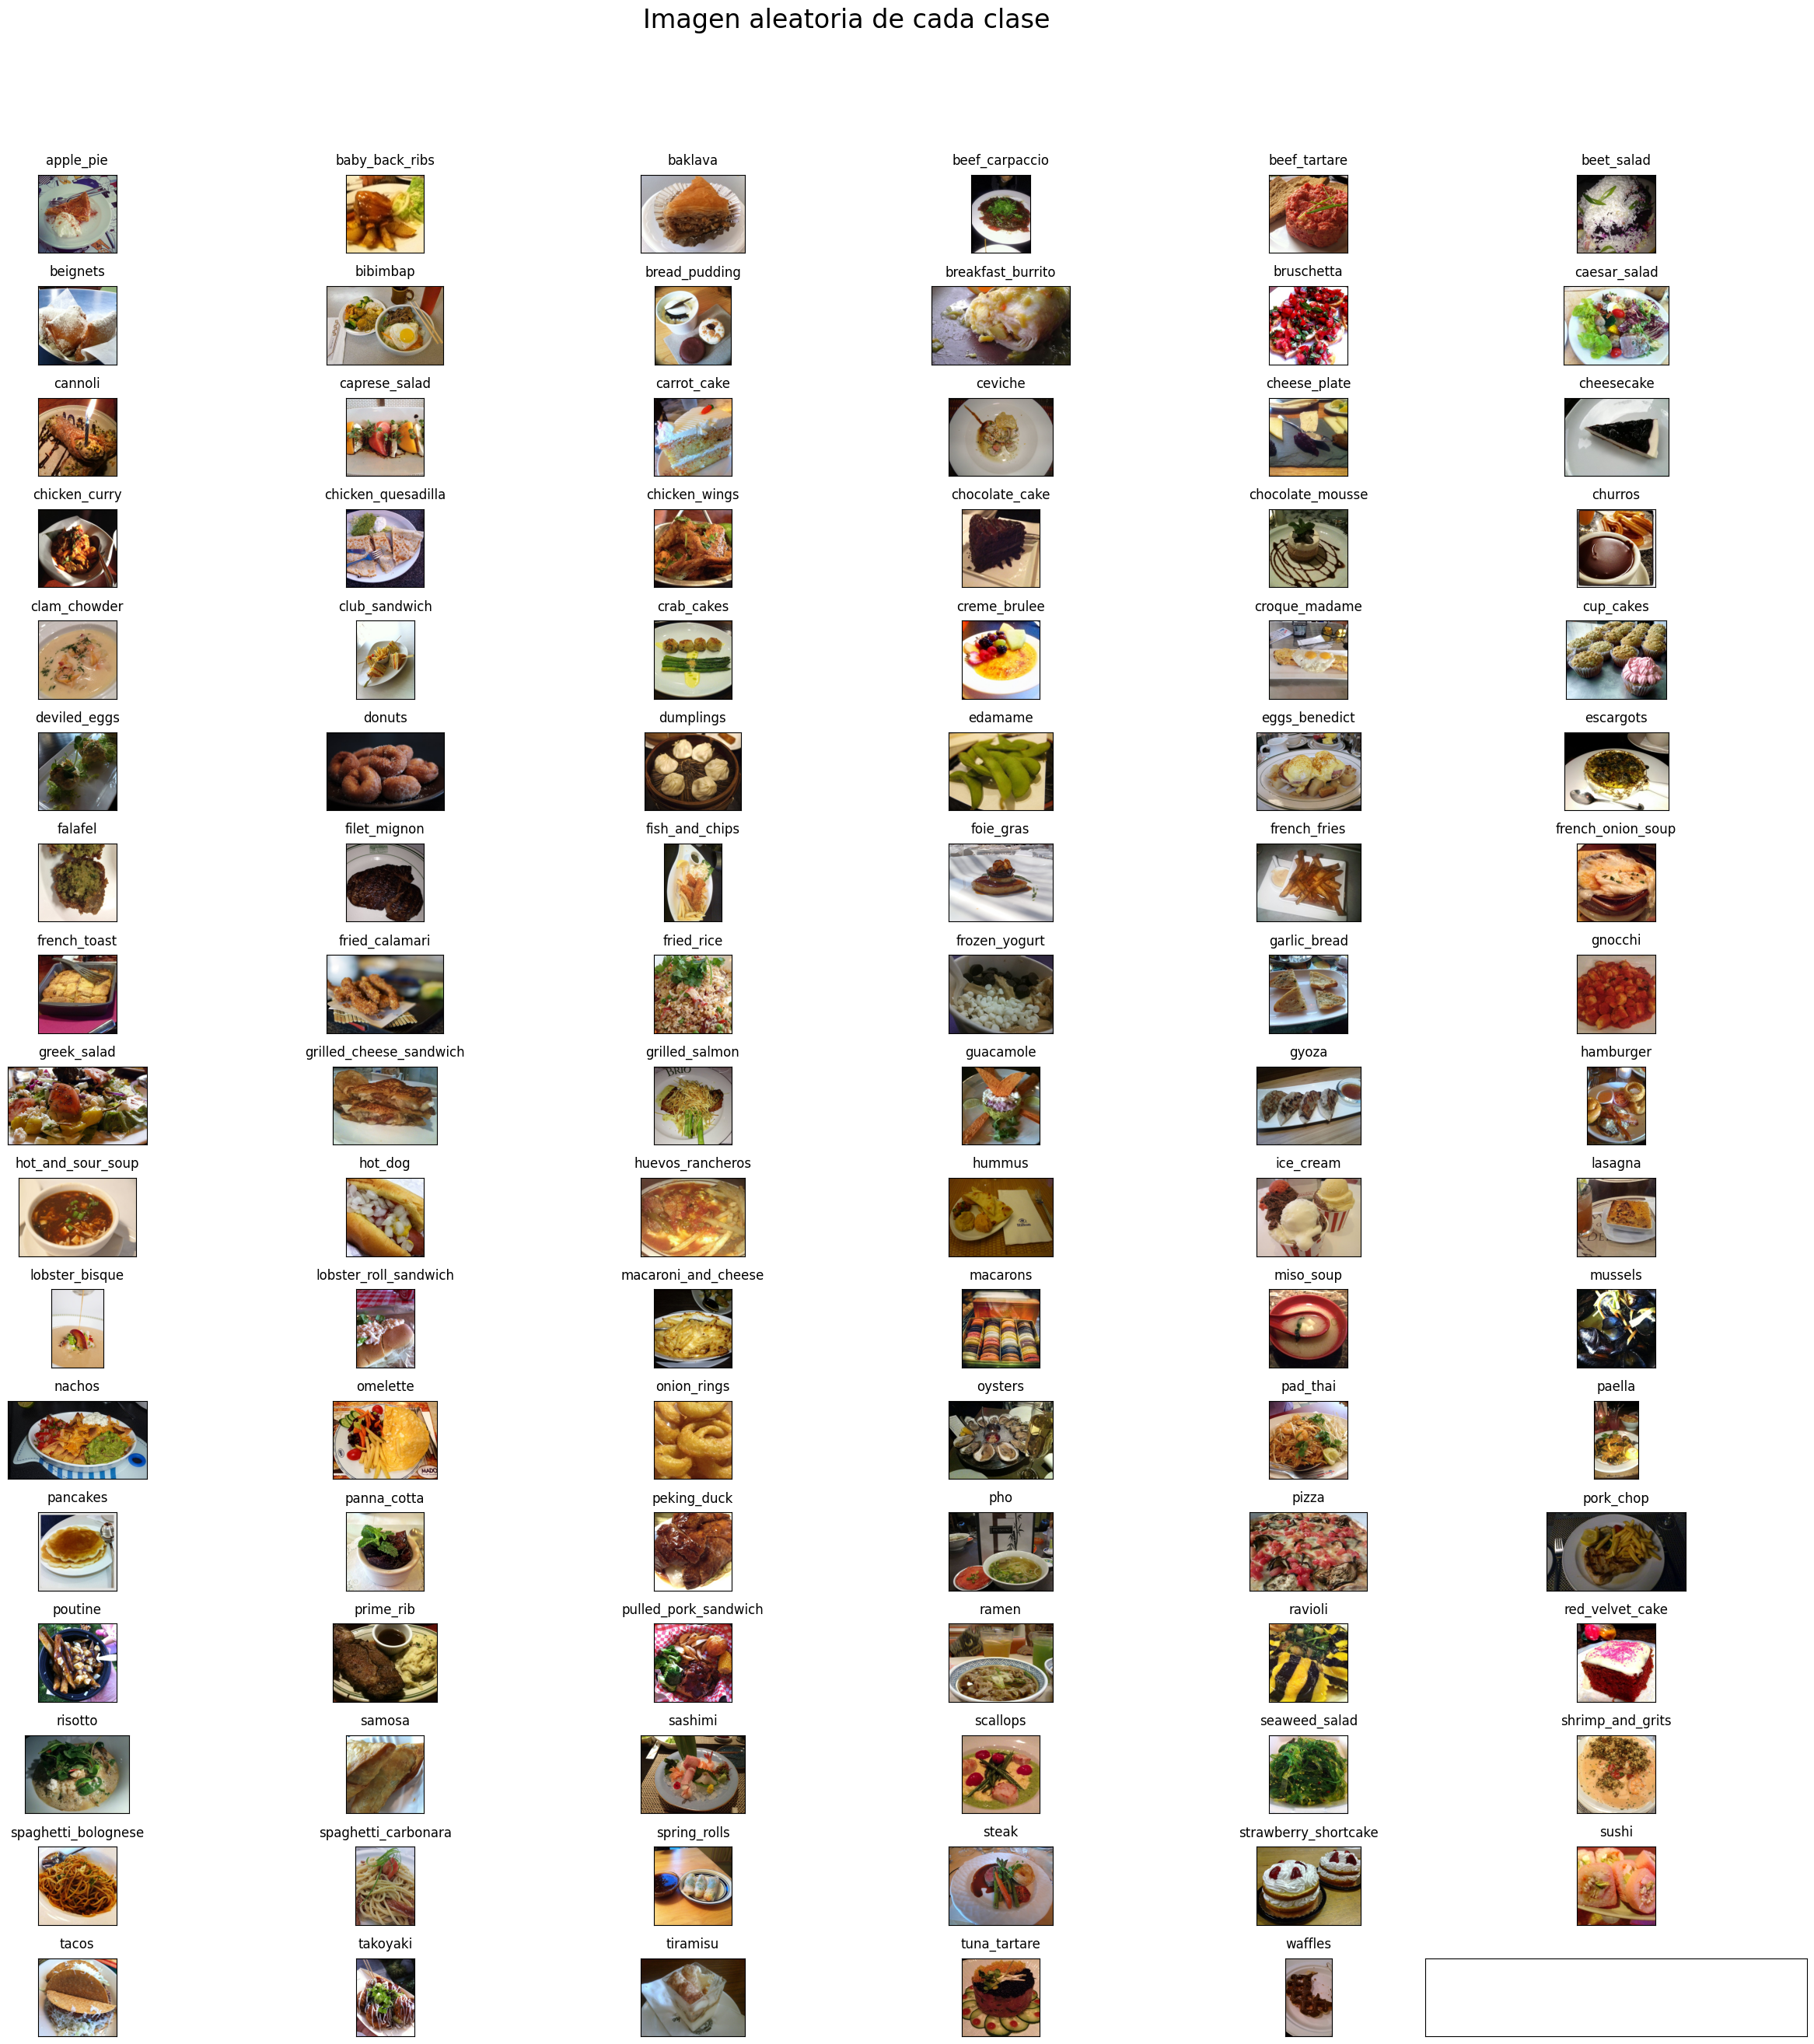

In [7]:
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Imagen aleatoria de cada clase", y=1.05, fontsize=24)
foods_sorted = sorted(os.listdir(base_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id]
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(base_dir,food_selected))
    food_selected_random = np.random.choice(food_selected_images)
    img = plt.imread(os.path.join(base_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)

plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()


## Entrenamiento del modelo

Asignamos las variables necesarias.

In [8]:
img_width, img_height = 200, 200
nb_train_samples = 80800
nb_validation_samples = 20200
batch_size = 8
epoch = 100

Realizamos la generalización de datos de entrenamiento y de validación.

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    brightness_range=[0.5, 1.5],
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.25)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

In [12]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset = "training")

validation_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset = "validation")

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


In [ ]:
# train_generator.class_indices = class_to_index
# validation_generator.class_indices = class_to_index

### Modelo con InceptionV3

Creamos el modelo integrando InceptionV3, una capa de agrupación global para convertir la salida 3D en un vector 1D, también capas densas con activación ReLU y dropout, y por último la capa de salida con la función de activación softmax ya que es un problema de clasificación múltiple.

In [ ]:
inception = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3))

x = inception.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(
    len(class_names),
    kernel_regularizer=l2(0.005), 
    activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)

Compila el modelo utilizando el optimizador SGD con una tasa de aprendizaje baja, función de pérdida categórica y métrica de precisión.

In [ ]:
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

Establecemos un callback para que se vaya guardando el modelo en cada iteracción, siempre que las métricas sean mejor que la anterior.

In [ ]:
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)
checkpointer = ModelCheckpoint(
    filepath='Modelos entrenados/best_model_trained.h5',
    verbose=1,
    save_best_only=True)

Utiliza el conjunto de datos de entrenamiento y validación para entrenar el modelo.

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch = len(train_generator),
                    validation_data = validation_generator,
                    validation_steps = len(validation_generator),
                    epochs = epoch,
                    verbose = 1,
                    callbacks = [early_stopper, checkpointer])

model.save('Modelos entrenados/model_inception_trained_compressed.h5', save_format='h5', include_optimizer=False)

Epoch 1/100
10100/10100 [==============================] - ETA: 0s - loss: 8.0541 - accuracy: 0.0767
Epoch 00001: val_loss improved from inf to 6.02183, saving model to Modelos entrenados\best_model_trained.h5
10100/10100 [==============================] - 896s 88ms/step - loss: 8.0541 - accuracy: 0.0767 - val_loss: 6.0218 - val_accuracy: 0.2165
Epoch 2/100
10100/10100 [==============================] - ETA: 0s - loss: 5.2998 - accuracy: 0.1895
Epoch 00002: val_loss improved from 6.02183 to 4.00133, saving model to Modelos entrenados\best_model_trained.h5
10100/10100 [==============================] - 884s 88ms/step - loss: 5.2998 - accuracy: 0.1895 - val_loss: 4.0013 - val_accuracy: 0.3080
Epoch 3/100
10100/10100 [==============================] - ETA: 0s - loss: 4.1038 - accuracy: 0.2308
Epoch 00003: val_loss improved from 4.00133 to 3.34407, saving model to Modelos entrenados\best_model_trained.h5
10100/10100 [==============================] - 881s 87ms/step - loss: 4.1038 - accurac

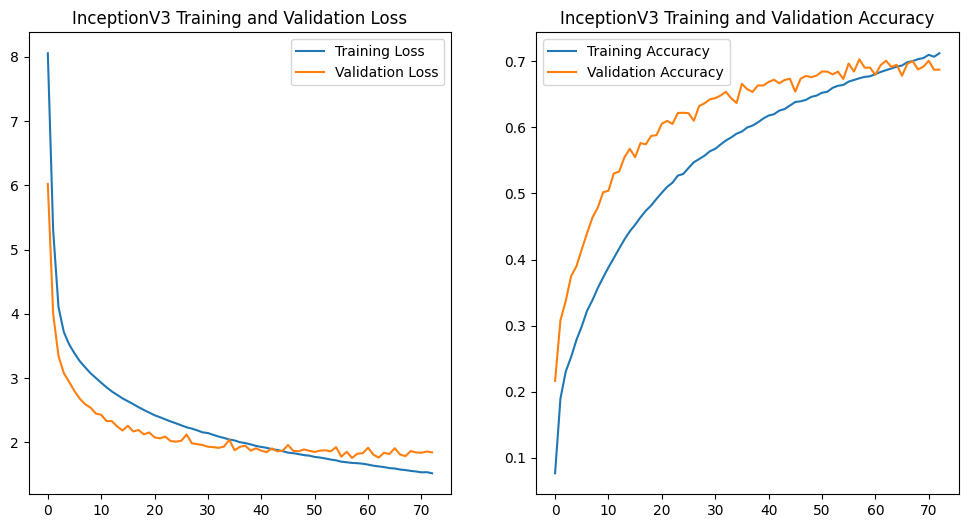

In [ ]:
plot = pd.DataFrame(history.history)

# Gráfica de pérdida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(plot['loss'], label='Training Loss')
plt.plot(plot['val_loss'], label='Validation Loss')
plt.legend()
plt.title('InceptionV3 Training and Validation Loss')

# Gráfica de accuracy
plt.subplot(1, 2, 2)
plt.plot(plot['accuracy'], label='Training Accuracy')
plt.plot(plot['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('InceptionV3 Training and Validation Accuracy')

# Mostrar las gráficas
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.

    pred = model.predict(img)
    index = np.argmax(pred)
    class_names.sort()
    pred_value = class_names[index]
    if show:
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
images = [
    "C:/Users/Silvia/Desktop/Github-Recofood/Modelo_Entrenamiento/Imagenes_Prediccion/donut.jpg",
    "C:/Users/Silvia/Desktop/Github-Recofood/Modelo_Entrenamiento/Imagenes_Prediccion/arroz-3-delicias.jpg",
    "C:/Users/Silvia/Desktop/Github-Recofood/Modelo_Entrenamiento/Imagenes_Prediccion/pizza.jpg"]

1/1 [==============================] - 0s 67ms/step


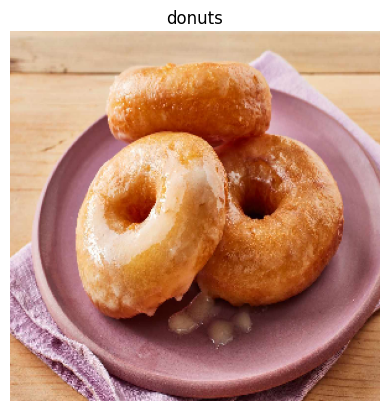

1/1 [==============================] - 0s 32ms/step


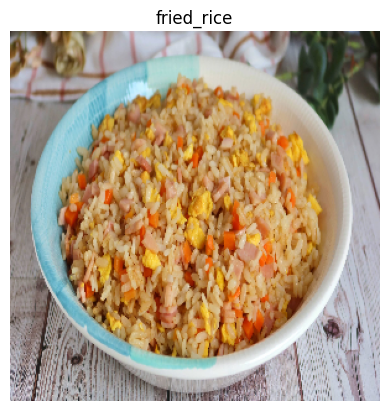

1/1 [==============================] - 0s 31ms/step


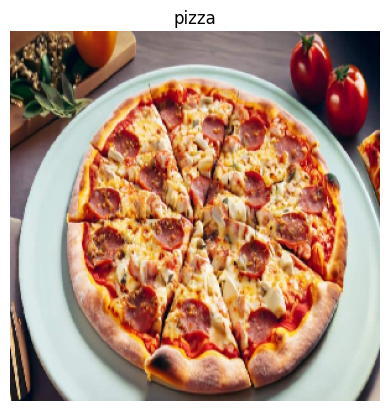

In [ ]:
predict_class(model, images, True)

### ResNet50

In [ ]:
resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3))

x_resnet = resnet.output
x_resnet = GlobalAveragePooling2D()(x_resnet)
x_resnet = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x_resnet)
x_resnet = Dropout(0.2)(x_resnet)

predictions_resnet = Dense(
    len(class_names),
    kernel_regularizer=l2(0.005),
    activation='softmax')(x_resnet)

model_resnet = Model(inputs=resnet.input, outputs=predictions_resnet)

In [ ]:
model_resnet.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


In [ ]:
early_stopping_resnet = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)

checkpointer_resnet = ModelCheckpoint(
    filepath='Modelos entrenados/best_model_resnet.h5',
    verbose=1,
    save_best_only=True)

In [ ]:
history_resnet = model_resnet.fit(train_generator,
                    steps_per_epoch = len(train_generator),
                    validation_data = validation_generator,
                    validation_steps = len(validation_generator),
                    epochs = epoch,
                    verbose = 1,
                    callbacks = [early_stopping_resnet, checkpointer_resnet])

model_resnet.save('Modelos entrenados/model_resnet_trained.h5')

Epoch 1/100
10100/10100 [==============================] - ETA: 0s - loss: 4.1221 - accuracy: 0.2657
Epoch 00001: val_loss improved from inf to 3.34555, saving model to Modelos entrenados\best_model_resnet.h5
10100/10100 [==============================] - 1093s 108ms/step - loss: 4.1221 - accuracy: 0.2657 - val_loss: 3.3455 - val_accuracy: 0.3433
Epoch 2/100
10100/10100 [==============================] - ETA: 0s - loss: 2.7136 - accuracy: 0.4205
Epoch 00002: val_loss improved from 3.34555 to 2.65895, saving model to Modelos entrenados\best_model_resnet.h5
10100/10100 [==============================] - 729s 72ms/step - loss: 2.7136 - accuracy: 0.4205 - val_loss: 2.6590 - val_accuracy: 0.4720
Epoch 3/100
10100/10100 [==============================] - ETA: 0s - loss: 2.4792 - accuracy: 0.4699
Epoch 00003: val_loss improved from 2.65895 to 2.43821, saving model to Modelos entrenados\best_model_resnet.h5
10100/10100 [==============================] - 728s 72ms/step - loss: 2.4792 - accuracy

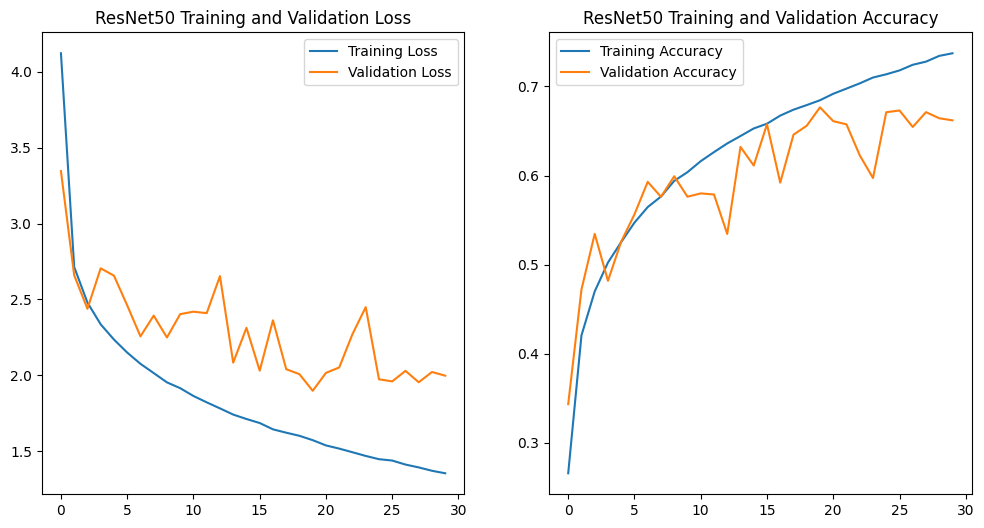

In [ ]:
plot = pd.DataFrame(history_resnet.history)

# Gráfica de pérdida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(plot['loss'], label='Training Loss')
plt.plot(plot['val_loss'], label='Validation Loss')
plt.legend()
plt.title('ResNet50 Training and Validation Loss')

# Gráfica de accuracy
plt.subplot(1, 2, 2)
plt.plot(plot['accuracy'], label='Training Accuracy')
plt.plot(plot['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('ResNet50 Training and Validation Accuracy')

# Mostrar las gráficas
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(150, 150))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.

    pred = model.predict(img)
    index = np.argmax(pred)
    class_names.sort()
    pred_value = class_names[index]
    if show:
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

1/1 [==============================] - 1s 1s/step


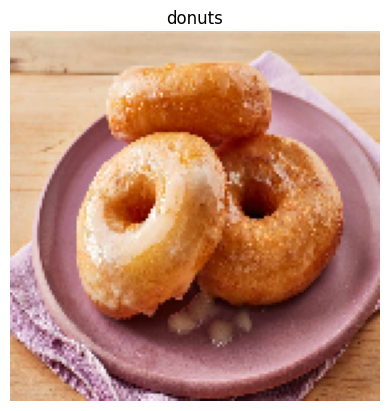

1/1 [==============================] - 0s 22ms/step


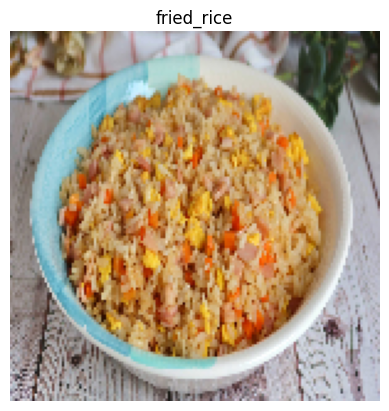

1/1 [==============================] - 0s 22ms/step


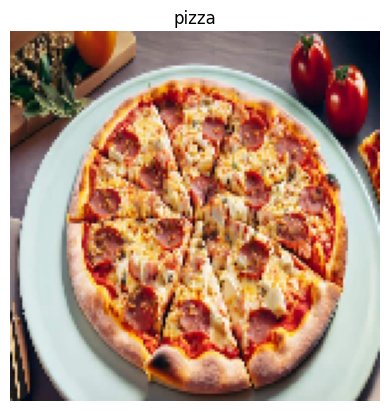

In [ ]:
predict_class(model_resnet, images, True)

### DenseNet121

In [ ]:
densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3))

x_densenet = densenet.output
x_densenet = GlobalAveragePooling2D()(x_densenet)
x_densenet = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x_densenet)
x_densenet = Dropout(0.2)(x_densenet)

predictions_densenet = Dense(
    len(class_names),
    kernel_regularizer=l2(0.005),
    activation='softmax')(x_densenet)

model_densenet = Model(inputs=densenet.input, outputs=predictions_densenet)

In [ ]:
model_densenet.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


In [ ]:
early_stopping_densenet = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)

checkpointer_densenet = ModelCheckpoint(
    filepath='Modelos entrenados/best_model_densenet.h5',
    verbose=1,
    save_best_only=True)

In [ ]:
history_densenet = model_densenet.fit(train_generator,
                    steps_per_epoch = len(train_generator),
                    validation_data = validation_generator,
                    validation_steps = len(validation_generator),
                    epochs = epoch,
                    verbose = 1,
                    callbacks = [early_stopping_densenet, checkpointer_densenet])

model_densenet.save('Modelos entrenados/model_densenet_trained.h5')

Epoch 1/100
10100/10100 [==============================] - ETA: 0s - loss: 4.1223 - accuracy: 0.2559
Epoch 00001: val_loss improved from inf to 2.54963, saving model to Modelos entrenados\best_model_densenet.h5
10100/10100 [==============================] - 1018s 100ms/step - loss: 4.1223 - accuracy: 0.2559 - val_loss: 2.5496 - val_accuracy: 0.4644
Epoch 2/100
10100/10100 [==============================] - ETA: 0s - loss: 2.7999 - accuracy: 0.4043
Epoch 00002: val_loss improved from 2.54963 to 2.29275, saving model to Modelos entrenados\best_model_densenet.h5
10100/10100 [==============================] - 993s 98ms/step - loss: 2.7999 - accuracy: 0.4043 - val_loss: 2.2927 - val_accuracy: 0.5061
Epoch 3/100
10100/10100 [==============================] - ETA: 0s - loss: 2.5746 - accuracy: 0.4538
Epoch 00003: val_loss improved from 2.29275 to 2.08343, saving model to Modelos entrenados\best_model_densenet.h5
10100/10100 [==============================] - 994s 98ms/step - loss: 2.5746 - ac

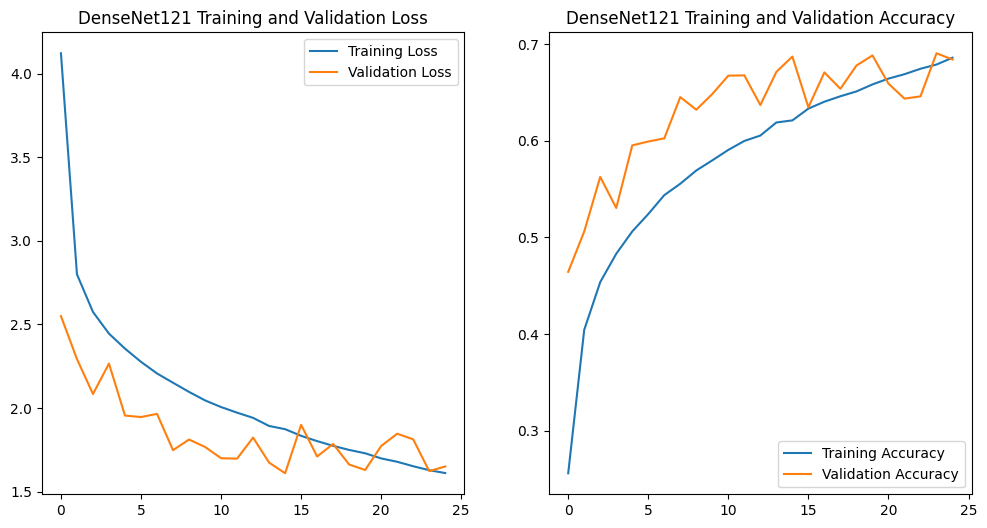

In [ ]:
plot = pd.DataFrame(history_densenet.history)

# Gráfica de pérdida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(plot['loss'], label='Training Loss')
plt.plot(plot['val_loss'], label='Validation Loss')
plt.legend()
plt.title('DenseNet121 Training and Validation Loss')

# Gráfica de accuracy
plt.subplot(1, 2, 2)
plt.plot(plot['accuracy'], label='Training Accuracy')
plt.plot(plot['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('DenseNet121 Training and Validation Accuracy')

# Mostrar las gráficas
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(150, 150))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.

    pred = model.predict(img)
    index = np.argmax(pred)
    class_names.sort()
    pred_value = class_names[index]
    if show:
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

1/1 [==============================] - 3s 3s/step


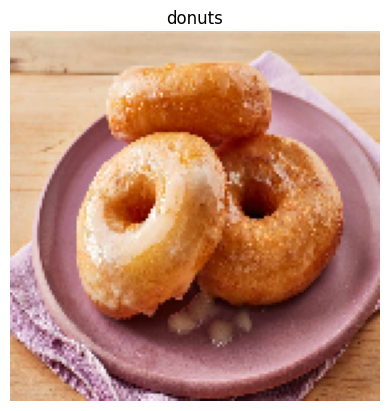

1/1 [==============================] - 0s 32ms/step


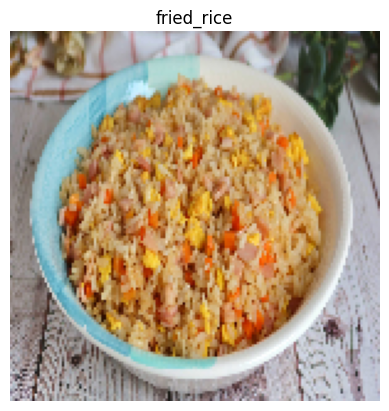

1/1 [==============================] - 0s 33ms/step


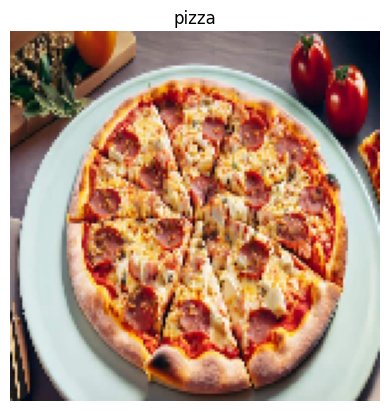

In [ ]:
predict_class(model_densenet, images, True)